**CS 4501 - Digital Signal Processing**

Phyl Peng (hp9psb), Brian Mbogo (bpm4pkz), Anna Williamson (amw4uet)

*Image filter design for different noise distributions*

# Part 1: A neural network to classify the noise distribution

Koehrsen, W. (2018). Transfer Learning with Convolutional Neural Networks in PyTorch. Towards Data Science. https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

In [16]:
from torchvision import transforms, datasets, models
from torchvision.models.resnet import Bottleneck
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, RandomSampler
import torch.nn as nn
from torchsummary import summary

from scipy.fft import ifft2
import seaborn as sns
import numpy as np
import pandas as pd
import os
from timeit import default_timer as timer

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [17]:
# Location of data
datadir = os.path.curdir
traindir = os.path.join(datadir, 'train')
validdir = os.path.join(datadir, 'valid')
testdir = os.path.join(datadir, 'valid')

save_file_name = os.path.join(datadir, 'noise-model.pt')
checkpoint_path = os.path.join(datadir, 'noise-model.pth')

batch_size = 32

In [18]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [19]:
model_seed = 12600
torch.random.manual_seed(model_seed)
train_on_gpu = cuda.is_available()
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], sampler=RandomSampler(data['train'], num_samples=200), batch_size=batch_size),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

n_classes = len(data['train'].classes)
print(f"n_classes: {n_classes} \n {data['train'].classes}")

n_classes: 2 
 ['gaussian', 'saltpepper']


In [20]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

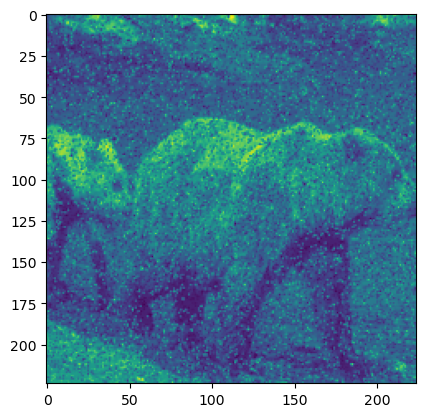

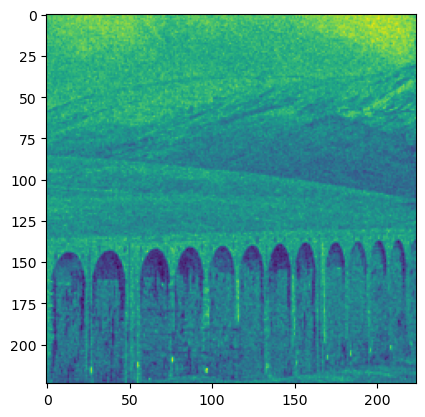

In [21]:
sp_example = features[labels == 1][0, 0] #salt and pepper
ga_example = features[labels == 0][0, 0] #gaussian
plt.imshow(sp_example)
plt.figure()
plt.imshow(ga_example)

In [22]:
def get_pretrained_model():
    model = models.vgg16(pretrained=True)

    # Freeze early layers
    for param in model.parameters():
      param.requires_grad = False
    
    #enable last convolution layer
    fl = len(model.features)
    for layer in model.features[fl-3:fl]:
      for param in layer.parameters():
        param.requires_grad = True

    #enable first 2 convolution layers
    '''for layer in model.features[0:6]:
      for param in layer.parameters():
        param.requires_grad = True'''

    #prepend transform layer to normalize fft channels
    model.features[0] = torch.nn.Sequential(
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    model.features[0]
)
    
    #enable other fully-connected layers
    for layer in model.classifier[1:]:
      for param in layer.parameters():
        param.requires_grad = True

    n_inputs = model.classifier[6].in_features

    # Add on classifier
    model.classifier[6] = nn.Sequential(
        nn.Linear(n_inputs, 2048), nn.ReLU(), nn.Dropout(0.2),
        nn.Linear(2048, 512), nn.ReLU(),
        nn.Linear(512, 256), nn.ReLU(),
        nn.Linear(256, n_classes), nn.Softmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    return model

In [33]:
model = get_pretrained_model()
print(summary(
        model, input_size=(3, 224, 224), batch_size=batch_size))

c:\Users\brian\miniconda3\envs\fun-stuff\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\brian\miniconda3\envs\fun-stuff\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Normalize: 3-1               --
|    |    └─Conv2d: 3-2                  (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18       

In [24]:
#get numerical value of each classification
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

print(list(model.idx_to_class.items()))

trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)

[(0, 'gaussian'), (1, 'saltpepper')]


In [35]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            #print(f"batch {ii}")
            # Clear gradients
            optimizer.zero_grad()
            
            #use fft in the other channels of the image
            imfft = ifft2(data[0, 0].numpy())
            data[0, 1] = torch.tensor(np.real(imfft))
            data[0, 2] = torch.tensor(np.imag(imfft))

            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            output = model(data)

            # Loss and backpropagation of gradients
            output = output[:, 1]
            loss = criterion(output, target.float())
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy
            pred = torch.round(output)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            #print(
            #    f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            #    end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    imfft = ifft2(data[0, 0].numpy())
                    data[0, 1] = torch.tensor(np.real(imfft))
                    data[0, 2] = torch.tensor(np.imag(imfft))

                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    output = model(data)
                    output = output[:, 1]
                    loss = criterion(output, target.float())
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    pred = torch.round(output)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        #print(
                        #    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        #)

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train loss', 'valid loss', 'train acc',
                                'valid acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    #print(
    #    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    #)
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train loss', 'valid loss', 'train acc', 'valid acc'])
    return model, history


In [36]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=15,
    n_epochs=30,
    print_every=1)

Model has been trained for: 1 epochs.


Epoch: 0 	Training Loss: 0.0601 	Validation Loss: 1.0563
		Training Accuracy: 6.33%	 Validation Accuracy: 60.47%

Epoch: 1 	Training Loss: 0.0456 	Validation Loss: 0.5227
		Training Accuracy: 6.71%	 Validation Accuracy: 75.81%

Epoch: 2 	Training Loss: 0.0223 	Validation Loss: 3.3548
		Training Accuracy: 7.42%	 Validation Accuracy: 56.74%

Epoch: 3 	Training Loss: 0.0154 	Validation Loss: 3.0625
		Training Accuracy: 7.71%	 Validation Accuracy: 58.60%

Epoch: 4 	Training Loss: 0.0122 	Validation Loss: 2.2320
		Training Accuracy: 7.75%	 Validation Accuracy: 65.81%

Epoch: 5 	Training Loss: 0.0091 	Validation Loss: 4.0250
		Training Accuracy: 8.08%	 Validation Accuracy: 57.91%

Epoch: 6 	Training Loss: 0.0068 	Validation Loss: 2.9681
		Training Accuracy: 8.17%	 Validation Accuracy: 60.70%

Epoch: 7 	Training Loss: 0.0097 	Validation Loss: 3.3192
		Training Accuracy: 7.92%	 Validation Accuracy: 61.86%

Epoch: 8 	Training Loss: 0.0138 	Validation Loss

KeyboardInterrupt: 

# Part 2: Filters to perform denoising by noise distribution

In [ ]:
# Gaussian Filter - used to remove noise and detail


'''
SOURCES:

https://www.cs.auckland.ac.nz/courss/compsci373s1c/PatricesLectures/Image%20Filtering.pdf
https://blog.en.uwa4d.com/2022/08/11/screen-post-processing-effects-chapter-1-basic-algorithm-of-gaussian-blur-and-its-implementation/
https://en.wikipedia.org/wiki/Salt-and-pepper_noise
https://www.geeksforgeeks.org/python-pil-getpixel-method/
https://stackoverflow.com/questions/52307290/what-is-the-difference-between-images-in-p-and-l-mode-in-pil#:~:text=If%20you%20have%20an%20L,stores%20a%20greyscale%2C%20not%20colour.
https://ijesc.org/upload/a2d11768dad7f56db1cc12bb3650879a.A%20Comparison%20of%20Salt%20and%20Pepper%20Noise%20Removal%20Filters.pdf
https://www.geeksforgeeks.org/python-pil-copy-method/
'''

'''
NOTES:

- "An effective noise reduction method for this type of noise is a median filter or a morphological filter."
- first attempt: median filter
- note: images are in "L"-mode... maps to black and white pixels/greyscale
- a median filter is the best of a variety of filters to handle salt and pepper noise
'''

def convolution2DPadded(px, width, height, gaussian_kernel, ks_w, ks_h):
    pad_x = ks // 2
    pad_y = ks // 2
    input_padded = np.pad(px, ((pad_x, pad_x), (pad_y, pad_y)), mode='constant')
        
    # Convolve the padded matrix with the Gaussian kernel
    return convolve2d(input_padded, gaussian_kernel, mode='valid')
    
def gaussianDiscrete2D(theta, x, y):
    g = 0
    for ySubPixel in [i * 0.1 for i in range(int(y - 0.5 * 10), int(y + 0.6 * 10))]:
        for xSubPixel in [i * 0.1 for i in range(int(x - 0.5 * 10), int(x + 0.6 * 10))]:
            g += ((1 / (2 * math.pi * theta * theta)) *
                  math.pow(math.e, -(xSubPixel * xSubPixel + ySubPixel * ySubPixel) / (2 * theta * theta)))
    g /= 121
    return g

def gaussian2D(theta, size):
    kernel = [[0 for i in range(size)] for j in range(size)]
    for j in range(size):
        for i in range(size):
            kernel[i][j] = gaussianDiscrete2D(theta, i - (size / 2), j - (size / 2))

    kernel_sum = sum([sum(row) for row in kernel])

    kernel = [[element / kernel_sum for element in row] for row in kernel]
    return kernel

def smooth(px, width, height, ks, theta):
    gaussian_kernel = gaussian2D(theta, ks)
    print(px.shape)
    output = convolution2DPadded(px, width, height, gaussian_kernel, ks, ks)
    return output

def smooth_image(px, w, h, ks, theta):
    input_2d = [[0 for i in range(w)] for j in range(h)]
    output_1d = [0 for i in range(w * h)]
    output_2d = [[0 for i in range(w)] for j in range(h)]
    output = [0 for i in range(w * h)]

#     for j in range(h):
#         for i in range(w):
#             input_2d[j][i] = Image.new('RGB', (1, 1), px[j * w + i]).convert('L').getpixel((0, 0))
    
    output_2d = smooth(px, w, h, ks, theta)
    print(len(output_1d))
    print(output_2d.shape)
#     for j in range(h):
#         for i in range(w):
#             output_1d[j * w + i] = output_2d[j][i]

#     for i in range(len(output_1d)):
#         grey = round(output_1d[i])
#         if grey > 255:
#              grey = 255
#         if grey < 0:
#             grey = 0
#         output[i] = Image.new('L', (1, 1), (grey)).getpixel((0, 0))

    return Image.fromarray(np.uint8(output_2d), 'L')

 
# load image
im = Image.open(r"/Users/philpeng/Documents/image-denoising/guassian_bridge.jpg")
px = imread("guassian_bridge.jpg")

w, h = px.shape
print("Original photo:")
display(im)
original_im = im.copy()

# filter image
print("Gaussian blurred photo:")
ks = 5
im = smooth_image(px, w, h, ks, 0.9)
display(im)


#print("Mean Squared Error:", MSE(original_im, im))